## Let's implement CCS from scratch.
This will deliberately be a simple (but less efficient) implementation to make everything as clear as possible.

In [23]:
from tqdm import tqdm, trange
import copy
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM, LlamaForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import random

In [24]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
setup_seed(42)

In [2]:
# Let's just try IMDB for simplicity
print("Loading data...")
# data = load_dataset("amazon_polarity")["test"]
with open("/root/zhenting_a5000/probing/data/lfqa_umd_transformed.jsonl", "r") as fin:
    data = [json.loads(line) for line in fin]
print("Data loaded.")

Loading data...
Data loaded.


In [3]:
# print(data)
print(len(data))
print(data[0])
print(data[0].keys())
print(data[0]['content'])
print(data[0]['label'])

1024
{'content': 'Q: why cant america just ban guns\nA: For the same reason you can’t ban free speech.  It is a constitutional freedom that was designed to be difficult dismantle.', 'label': 0}
dict_keys(['content', 'label'])
Q: why cant america just ban guns
A: For the same reason you can’t ban free speech.  It is a constitutional freedom that was designed to be difficult dismantle.
0


In [4]:
# Here are a few different model options you can play around with:
# model_name = "deberta"
# model_name = "gpt-j"
# model_name = "t5"
model_name = "llama"

# if you want to cache the model weights somewhere, you can specify that here
cache_dir = "/root/autodl-fs/model_cache"

if model_name == "deberta":
    model_type = "encoder"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model.cuda()
elif model_name == "gpt-j":
    model_type = "decoder"
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model.cuda()
elif model_name == "t5":
    model_type = "encoder_decoder"
    tokenizer = AutoTokenizer.from_pretrained("t5-11b", cache_dir=cache_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-11b", cache_dir=cache_dir)
    model.parallelize()  # T5 is big enough that we may need to run it on multiple GPUs
elif model_name == "llama":
    model_type = "decoder"
    tokenizer = AutoTokenizer.from_pretrained("/root/autodl-fs/llama/llama-2-7b-chat-to-hf/")
    tokenizer.padding_side = "left"
    tokenizer.pad_token = tokenizer.eos_token
    model = LlamaForCausalLM.from_pretrained("/root/autodl-fs/llama/llama-2-7b-chat-to-hf/").half().cuda().eval() #! add "half()" to fit in a smaller GPU
else:
    print("Not implemented!")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## First let's write code for extracting hidden states given a model and text. 
How we do this exactly will depend on the type of model.

In [5]:
def get_encoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, truncation=True, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["hidden_states"]
    
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_encoder_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder-decoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    decoder_text_ids = tokenizer("", return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, decoder_input_ids=decoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["encoder_hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize (adding the EOS token this time)
    input_ids = tokenizer(input_text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    # get the last layer, last token hidden states
    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_hidden_states(model, tokenizer, input_text, layer=-1, model_type="encoder"):
    fn = {"encoder": get_encoder_hidden_states, "encoder_decoder": get_encoder_decoder_hidden_states,
          "decoder": get_decoder_hidden_states}[model_type]

    return fn(model, tokenizer, input_text, layer=layer)

## Now let's write code for formatting data and for getting all the hidden states.

In [86]:
def format_imdb(text, label):
    """
    Given an imdb example ("text") and corresponding label (0 for negative, or 1 for positive), 
    returns a zero-shot prompt for that example (which includes that label as the answer).
    
    (This is just one example of a simple, manually created prompt.)
    """
    return "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text


def format_customized(text, label):
    return "The answer to the following QA is given by " + ["human", "machine"][label] + ":\n" + text


def get_hidden_states_many_examples(model, tokenizer, data, model_type, n=1024):
    """
    Given an encoder-decoder model, a list of data, computes the contrast hidden states on n random examples.
    Returns numpy arrays of shape (n, hidden_dim) for each candidate label, along with a boolean numpy array of shape (n,)
    with the ground truth labels
    
    This is deliberately simple so that it's easy to understand, rather than being optimized for efficiency
    """
    # setup
    print(f"Size of data: {len(data)}")
    model.eval()
    all_neg_hs, all_pos_hs, all_gt_labels = [], [], []

    # loop: sample n data items 
    for _ in tqdm(range(n)):
        #! for simplicity, sample a random example until we find one that's a reasonable length
        # (most examples should be a reasonable length, so this is just to make sure)
        while True:
            idx = np.random.randint(len(data))
            text, true_label = data[idx]["content"], data[idx]["label"]
            # the actual formatted input will be longer, so include a bit of a marign
            if len(tokenizer(text)) < 400:  
                break
                
        #! get hidden states
        neg_hs = get_hidden_states(model, tokenizer, input_text=format_customized(text, 0), model_type=model_type)
        pos_hs = get_hidden_states(model, tokenizer, input_text=format_customized(text, 1), model_type=model_type)

        # collect
        all_neg_hs.append(neg_hs)
        all_pos_hs.append(pos_hs)
        all_gt_labels.append(true_label)

    all_neg_hs = np.stack(all_neg_hs)
    all_pos_hs = np.stack(all_pos_hs)
    all_gt_labels = np.stack(all_gt_labels)

    return all_neg_hs, all_pos_hs, all_gt_labels

In [87]:
neg_hs, pos_hs, y = get_hidden_states_many_examples(model, tokenizer, data, model_type)

Size of data: 1024


100%|██████████| 1024/1024 [03:03<00:00,  5.57it/s]


## Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if logistic regression accuracy is bad, there's no hope of CCS doing well.

In [88]:
# let's create a simple 50/50 train split (the data is already randomized)
n = len(y)  # number of samples
neg_hs_train, neg_hs_test = neg_hs[:n//2], neg_hs[n//2:]
pos_hs_train, pos_hs_test = pos_hs[:n//2], pos_hs[n//2:]
y_train, y_test = y[:n//2], y[n//2:]

# for simplicity we can just take the difference between positive and negative hidden states
# 这个相减之后的向量可以理解为“正转负所需的变化向量”，既从pos到neg的语义转变所需要的向量
# 能训练一个好的线性分类器，就意味着，模型对于 转向真负语义(y=0)/没转向真负语义(y=1) 的变化向量 有线性边界，也就意味着模型“知道”一个语义本身是正是负
# (concatenating also works fine)
x_train = neg_hs_train - pos_hs_train
x_test = neg_hs_test - pos_hs_test

lr = LogisticRegression(class_weight="balanced")
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
# print(predictions)
# print(y_test)
accuracy, precision, recall, f1 = (f(y_test, predictions) for f in [accuracy_score, precision_score, recall_score, f1_score])
print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}")
# print("Logistic regression accuracy: {}".format(lr.score(x_test, y_test)))

accuracy: 0.99609375, precision: 0.9925373134328358, recall: 1.0, f1: 0.9962546816479401


## Now let's try CCS

In [89]:
class MLPProbe(nn.Module):
    #! 一个比LogisticRegression稍复杂一些的探针
    def __init__(self, d, hidden_size=8192, more_layers=6):
        super().__init__()
        self.linear_start = nn.Linear(d, hidden_size)
        self.act_start = nn.ReLU()
        if more_layers > 0:
            self.more_layers = nn.Sequential([nn.Linear, nn.ReLU] * more_layers)
        self.linear_end = nn.Linear(hidden_size, 1)
        self.act_end = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_start(x)
        x = self.act_start(x)
        if self.more_layers:
            x = self.more_layers(x)
        x = self.linear_end(x)
        x = self.act_end(x)
        return x

class CCS(object):
    def __init__(self, 
                 x0, x1, 
                 nepochs=5000, ntries=1, lr=1e-4, batch_size=-1, 
                 verbose=False, device="cuda", linear=True, weight_decay=0.01, var_normalize=False):
        # data
        self.var_normalize = var_normalize
        self.x0 = self.normalize(x0)
        self.x1 = self.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # probe
        self.linear = linear
        self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)

        
    def initialize_probe(self):
        if self.linear:
            self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
        else:
            self.probe = MLPProbe(self.d)
        self.probe.to(self.device)    


    def normalize(self, x):
        """
        Mean-normalizes the data x (of shape (n, d))
        If self.var_normalize, also divides by the standard deviation
        """
        normalized_x = x - x.mean(axis=0, keepdims=True)
        if self.var_normalize:
            normalized_x /= normalized_x.std(axis=0, keepdims=True)

        return normalized_x

        
    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1
    

    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()
        acc = max(acc, 1 - acc)

        return acc
    
    
    def get_acc_precision_recall_f1(self, x0_test, x1_test, y_test):
        x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]

        accuracy, precision, recall, f1 = (f(y_test, predictions) for f in [accuracy_score, precision_score, recall_score, f1_score])
        print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}")
        
        
    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        # Start training (full batch)
        loss_list= []
        for epoch in trange(self.nepochs):
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]
            
                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)

                # get the corresponding loss
                loss = self.get_loss(p0, p1)
                loss_list.append(loss.detach().cpu().item())

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        plt.plot(list(range(len(loss_list))), loss_list)
        plt.show()
        
        return loss.detach().cpu().item()
    
    def repeated_train(self):
        best_loss = np.inf

        for train_num in range(self.ntries):
            self.initialize_probe()
            loss = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss

        return best_loss

  2%|▏         | 124/5000 [00:00<00:07, 623.41it/s]

100%|██████████| 5000/5000 [00:09<00:00, 525.77it/s]


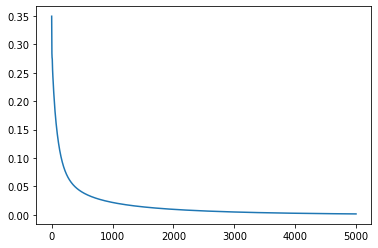

accuracy: 0.623046875, precision: 0.6308243727598566, recall: 0.6616541353383458, f1: 0.6458715596330274


In [90]:
# Train CCS without any labels
ccs = CCS(neg_hs_train, pos_hs_train)
ccs.repeated_train()

# Evaluate
ccs.get_acc_precision_recall_f1(neg_hs_test, pos_hs_test, y_test)
# print("CCS accuracy: {}".format(ccs_acc))